<a href="https://colab.research.google.com/github/LakshyaMalhotra/time-series-analysis/blob/main/time_series_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# library imports
import os
import gc
import datetime

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# plot formatting
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 14
sns.set_palette('Set2')
colors = list(sns.color_palette('Set2'))

In [3]:
def convert_to_dt(x):
    return datetime.datetime.strptime(x, '%m/%d/%Y')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/amazon_revenue_profit.csv', 
                 parse_dates=['Quarter'], date_parser=convert_to_dt)
df.head()

,Quarter,Revenue,Net Income
0,2020-03-31,75452,2535
1,2019-12-31,87437,3268
2,2019-09-30,69981,2134
3,2019-06-30,63404,2625
4,2019-03-31,59700,3561


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Quarter     61 non-null     datetime64[ns]
 1   Revenue     61 non-null     int64         
 2   Net Income  61 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 KB


In [6]:
def missing_values(df):
    data = pd.DataFrame(df.isnull().sum())
    data.columns = ['# missing']
    data['% missing'] = np.round((100 * data['# missing'])/df.shape[0], 2)
    return data

In [7]:
# printing basic info about the data
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')
print(f"\nFeatures:\n{'-'*10}\n{df.columns.tolist()}")
print(f'\nMissing values:\n{"-"*15}\n{missing_values(df)}')
print(f'\nUnique values:\n{"-"*15}\n{df.nunique()}')

Rows: 61
Columns: 3

Features:
----------
['Quarter', 'Revenue', 'Net Income']

Missing values:
---------------
            # missing  % missing
Quarter             0        0.0
Revenue             0        0.0
Net Income          0        0.0

Unique values:
---------------
Quarter       61
Revenue       61
Net Income    57
dtype: int64


In [8]:
df.set_index('Quarter', inplace=True)

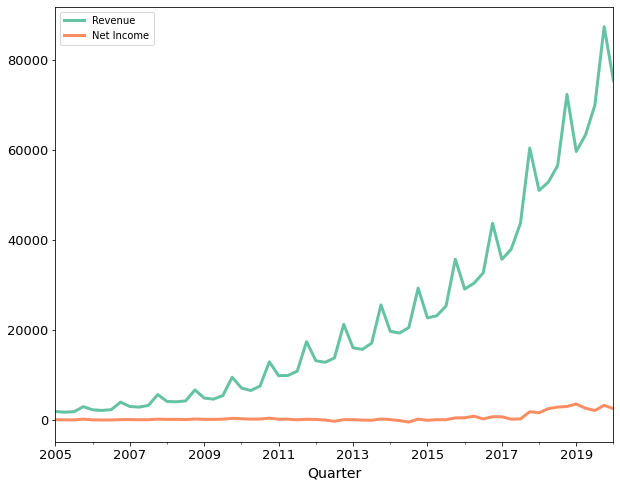

In [16]:
df.plot(lw=3);

In [20]:
fig = go.Figure()
trace = go.Scatter(x=df.index, y=df.Revenue, name='Amazon Revenue over the years', 
                   text=df.index, mode='lines', marker=dict(color='rgb(102,194,165)'))
fig.add_trace(trace)

layout = dict(
    title='Amazon revenue over the years',
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                 dict(count=1, label='1y', step='year', stepmode='backward'),
                 dict(count=3, label='3y', step='year', stepmode='backward'),
                 dict(count=5, label='5y', step='year', stepmode='backward'),
                 dict(step='all'),
                ]
            )
        ),
        rangeslider=dict(
            visible=True
        ),
        type='date'
    )
)
fig.update_layout(layout)
fig.show()

We can see the time-series almost stays stationary till about year 2010 but afterwards it is non-stationary as we can see from the non-linear trend.

Let's try to explore this further with the help of hypothesis testing:

- $H_{0}$ : data is stationary
- $H_{a}$ : data is non-stationary

In [21]:
from statsmodels.tsa.stattools import kpss

In [26]:
tstest = kpss(df['Revenue'], regression='c')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



In [27]:
tstest

(0.5827432403327967,
 0.024205159969745753,
 11,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

The second element of the `tstest` variable is the `p-value` which for a threshold of 5% suggests to reject the null hypothesis in favor of alternate. This means the data is non-stationary and has some trend as expected.

Now in order to decompose our time-series we could either choose additive or multiplicative model. Additive models are usually employed for stationary data whereas multiplicative models are used for non-stationary data. They are defined as follows:
- __Additive:__ $y_{t} = T_{t} + C_{t} + S_{t} + I_{t}$ ;
- __Multiplicative:__ $y_{t} = T_{t} \times C_{t} \times S_{t} \times I_{t}$ 

where $T_{t}$ = Trend, $C_{t}$ = Cyclic, $S_{t}$ = Seasonality, and $I_{t}$ = residual.

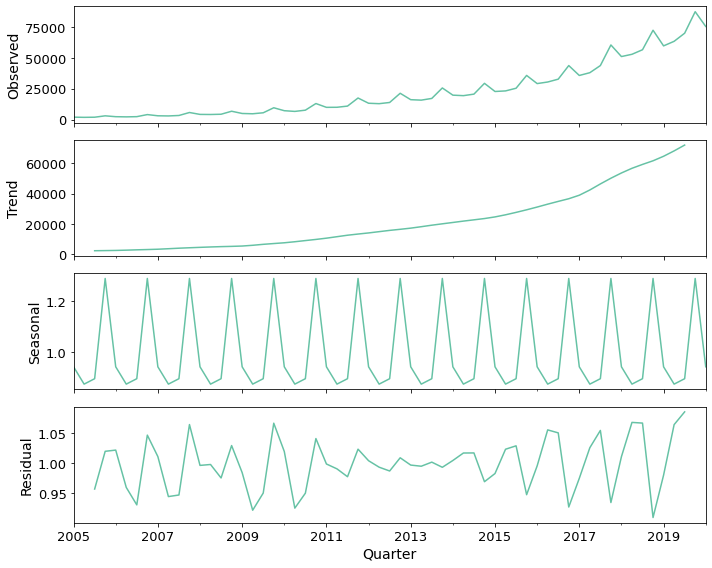

In [30]:
# decomposition
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df.Revenue, model='multiplicative')

resplot = res.plot();

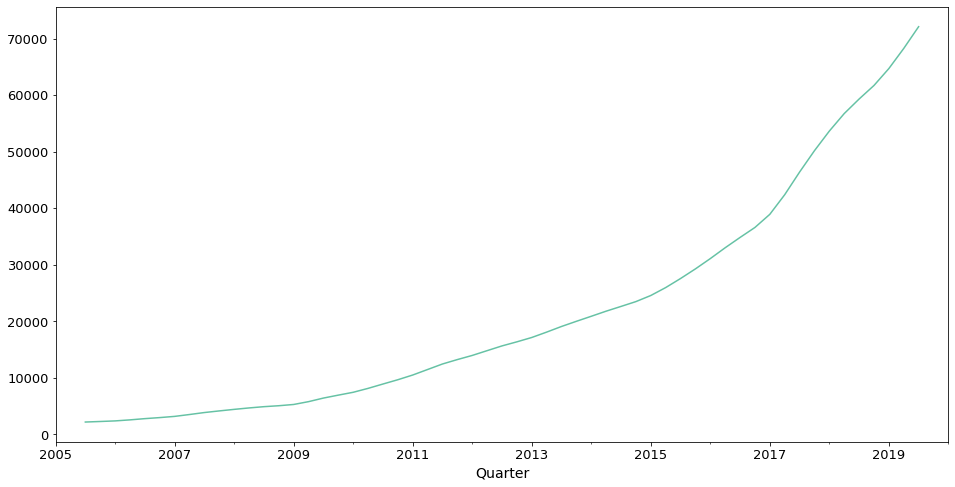

In [31]:
# taking only the trend plot
plt.figure(figsize=(16,8))
res.trend.plot();

In [37]:
print(f"Observed:\n{'-'*10}\n{res.observed}")
print(f"Trend:\n{'-'*6}\n{res.trend}")
print(f"Seasonal:\n{'-'*10}\n{res.seasonal}")
print(f"Residual:\n{'-'*10}\n{res.resid}")

Observed:
----------
Quarter
2020-03-31    75452
2019-12-31    87437
2019-09-30    69981
2019-06-30    63404
2019-03-31    59700
              ...  
2006-03-31     2279
2005-12-31     2977
2005-09-30     1858
2005-06-30     1753
2005-03-31     1902
Name: Revenue, Length: 61, dtype: int64
Trend:
------
Quarter
2020-03-31          NaN
2019-12-31          NaN
2019-09-30    72099.500
2019-06-30    68248.750
2019-03-31    64691.375
                ...    
2006-03-31     2369.375
2005-12-31     2265.000
2005-09-30     2169.625
2005-06-30          NaN
2005-03-31          NaN
Name: Revenue, Length: 61, dtype: float64
Seasonal:
----------
Quarter
2020-03-31    0.941840
2019-12-31    1.289518
2019-09-30    0.894993
2019-06-30    0.873649
2019-03-31    0.941840
                ...   
2006-03-31    0.941840
2005-12-31    1.289518
2005-09-30    0.894993
2005-06-30    0.873649
2005-03-31    0.941840
Name: Revenue, Length: 61, dtype: float64
Residual:
----------
Quarter
2020-03-31         NaN
2019-12

We can easily check that for a multiplicative model, the observed values are the product of trend, seasonal and residual.

In [38]:
print(res.observed[2])
print(res.trend[2]*res.seasonal[2]*res.resid[2])

69981
69980.99999999999


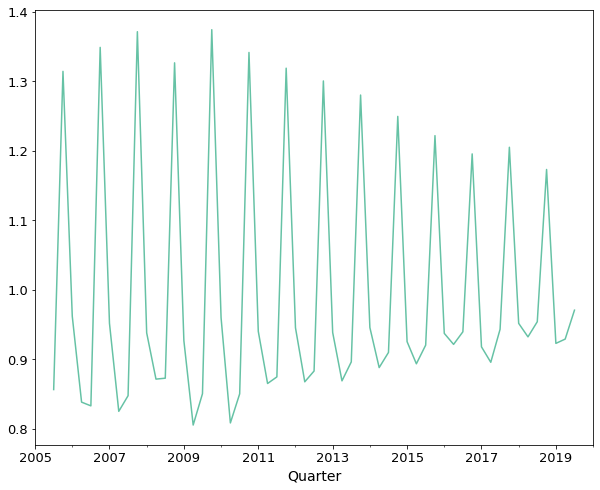

In [42]:
(res.observed/res.trend).plot();

We can see that the data does not have any trend once we divide the observed value with the trend. It, however, still captures the seasonality of the data and we can again check that this data is more or less stationary. Let's verify it again with the hypothesis testing-

- $H_{0}$ : data is stationary
- $H_{a}$ : data is non-stationary

In [45]:
no_trend_ts = pd.Series(res.observed / res.trend)
no_trend_ts = no_trend_ts.dropna()

In [46]:
ntts_test = kpss(no_trend_ts, regression='c')
ntts_test

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



(0.45193604279380284,
 0.054768947071636716,
 11,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

We can clearly see that for a threshold of 5%, the `p-value` exceeds the critical value which means we do not have enough evidence to reject the null-hypothesis. Hence, it is safe to say that the data is stationary!